<a href="https://colab.research.google.com/github/andmartins7/deep-neural-networks/blob/main/Classificacao_de_Imagens_de_Esportes_usando_Redes_Neurais_Convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
import os

# Montar o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definir transformações para pré-processamento dos dados
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Carregar o dataset usando torchvision.datasets.ImageFolder
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Sports/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Sports/test', transform=transform)
validset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Sports/valid', transform=transform)

# Criar dataloaders para carregar os dados em lotes durante o treinamento
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=False)

In [ ]:
# Definir a arquitetura do Modelo 1 (CNN usando torchvision.models)
model1 = torchvision.models.resnet18(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, 100)  # 100 classes no conjunto de dados

# Definir a arquitetura do Modelo 2 (implementação manual usando nn.Conv2d)
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 56 * 56, 100)  # 32 * 56 * 56 é o tamanho da saída após as convoluções

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc(x)
        return x

model2 = Model2()

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 258MB/s]


In [ ]:
# Função para calcular a acurácia
def get_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
yubn # Treinamento e avaliação dos modelos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model2 = model2.to(device)
num_epochs = 10
train_loss1, train_acc1, test_acc1 = [], [], []
train_loss2, train_acc2, test_acc2 = [], [], []

for epoch in range(num_epochs):
    running_loss1, running_loss2 = 0.0, 0.0
    total_correct1, total_correct2 = 0, 0

    import torch.cuda as cuda
    from torch.cuda.amp import autocast, GradScaler
    cuda.empty_cache()
    scaler = GradScaler()

    # Treinamento do Modelo 2
    model2.train()
    with torch.cuda.amp.autocast():
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer2.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model2(inputs)
                labels = labels.repeat(outputs.size(0) // labels.size(0))  # Repetir rótulos para corresponder ao tamanho do lote
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer2)
            scaler.update()
            running_loss2 += loss.item()
            total_correct2 += (labels == outputs.argmax(dim=1)).sum().item()

    train_loss2.append(running_loss2 / len(trainloader))
    train_acc2.append(total_correct2 / len(trainset))

    cuda.empty_cache()
    scaler = GradScaler()

    # Treinamento do Modelo 1
    model1.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss1 += loss.item()
        total_correct1 += (labels == outputs.argmax(dim=1)).sum().item()
    train_loss1.append(running_loss1 / len(trainloader))
    train_acc1.append(total_correct1 / len(trainset))

    # Avaliação dos modelos no conjunto de teste
    model1.eval()
    model2.eval()
    total_correct1, total_correct2 = 0, 0
    predictions1, predictions2 = [], []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)
            labels1 = labels.repeat(outputs1.size(0) // labels.size(0))  # Repetir rótulos para corresponder ao tamanho do lote do modelo 1
            labels2 = labels.repeat(outputs2.size(0) // labels.size(0))  # Repetir rótulos para corresponder ao tamanho do lote do modelo 2
            total_correct1 += (labels1 == outputs1.argmax(dim=1)).sum().item()
            total_correct2 += (labels2 == outputs2.argmax(dim=1)).sum().item()
            predictions1.extend(outputs1.argmax(dim=1).cpu().numpy())  # Salvar as predições do modelo 1
            predictions2.extend(outputs2.argmax(dim=1).cpu().numpy())  # Salvar as predições do modelo 2

    test_acc1.append(total_correct1 / len(testset))
    test_acc2.append(total_correct2 / len(testset))

    # Imprimir os resultados após cada época
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Model 1 - Train Loss: {train_loss1[epoch]:.4f}, Train Accuracy: {train_acc1[epoch]:.4f}, Test Accuracy: {test_acc1[epoch]:.4f}")
    print(f"Model 2 - Train Loss: {train_loss2[epoch]:.4f}, Train Accuracy: {train_acc2[epoch]:.4f}, Test Accuracy: {test_acc2[epoch]:.4f}")
    print()

Epoch 1/10:
Model 1 - Train Loss: 3.5644, Train Accuracy: 0.2952, Test Accuracy: 0.6240
Model 2 - Train Loss: 4.6122, Train Accuracy: 0.1592, Test Accuracy: 0.1700

Epoch 2/10:
Model 1 - Train Loss: 1.7393, Train Accuracy: 0.7229, Test Accuracy: 0.8220
Model 2 - Train Loss: 6.1435, Train Accuracy: 0.2106, Test Accuracy: 0.1340

Epoch 3/10:
Model 1 - Train Loss: 1.0397, Train Accuracy: 0.8329, Test Accuracy: 0.8840
Model 2 - Train Loss: 9.7923, Train Accuracy: 0.1817, Test Accuracy: 0.1600

Epoch 4/10:
Model 1 - Train Loss: 0.7196, Train Accuracy: 0.8864, Test Accuracy: 0.9100
Model 2 - Train Loss: 4.6077, Train Accuracy: 0.1862, Test Accuracy: 0.1600

Epoch 5/10:
Model 1 - Train Loss: 0.5361, Train Accuracy: 0.9192, Test Accuracy: 0.9240
Model 2 - Train Loss: 4.6069, Train Accuracy: 0.1862, Test Accuracy: 0.1600

Epoch 6/10:
Model 1 - Train Loss: 0.4155, Train Accuracy: 0.9432, Test Accuracy: 0.9200
Model 2 - Train Loss: 4.6067, Train Accuracy: 0.1862, Test Accuracy: 0.1600

Epoch 7/10

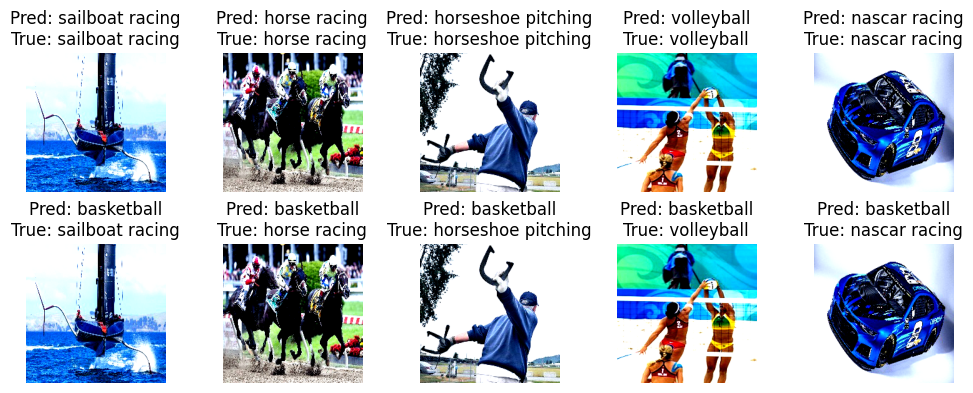

In [ ]:
# Exibir algumas amostras do conjunto de teste com as predições dos modelos
classes = trainset.classes

def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

num_samples = 5  # Número de amostras para exibir
indices = np.random.choice(len(testset), size=num_samples, replace=False)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    sample_img, sample_label = testset[idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    pred1 = classes[predictions1[idx]]
    pred2 = classes[predictions2[idx]]
    true_label = classes[sample_label]

    plt.subplot(2, num_samples, i + 1)
    imshow(sample_img.cpu().squeeze())
    plt.title(f"Pred: {pred1}\nTrue: {true_label}")
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    imshow(sample_img.cpu().squeeze())
    plt.title(f"Pred: {pred2}\nTrue: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

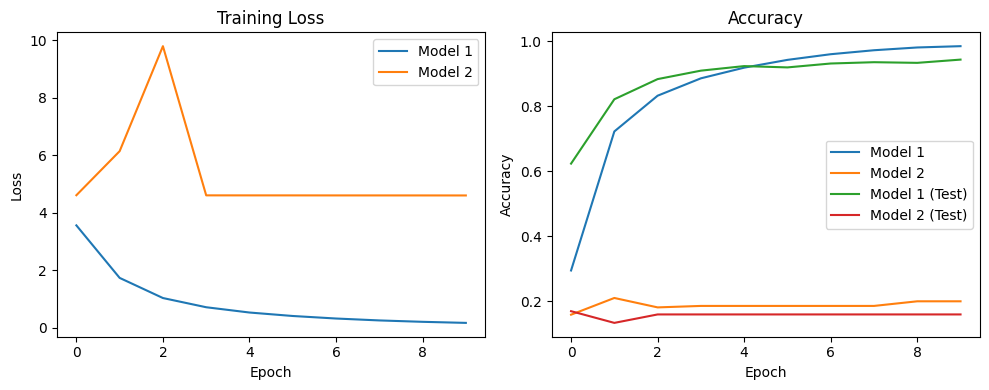

In [ ]:
# Plotar as métricas de treinamento e teste ao longo das épocas
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss1, label='Model 1')
plt.plot(train_loss2, label='Model 2')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc1, label='Model 1')
plt.plot(train_acc2, label='Model 2')
plt.plot(test_acc1, label='Model 1 (Test)')
plt.plot(test_acc2, label='Model 2 (Test)')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()